# <center>Image captioning model training

In [1]:
from src.net_modules.model import Model
from src.data_processing.dataset import FlickrDataset, Collate
from src.data_processing.vocabulary import Vocabulary
from src.utils.predictor import Predictor
from src.utils.history import History
from torch.utils.data import DataLoader
import pandas as pd
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping
from lightning.pytorch.loggers import CSVLogger
import torch
from multiprocessing import cpu_count
torch.set_float32_matmul_precision('high')
# Project constants
NUM_WORKERS = cpu_count()
MAX_EPOCHS = 30
BATCH_SIZE = 32
IMGS_PATH = '/mnt/s/CV/flickr30k/flickr30k_images'
CAPTIONS_PATH = '/mnt/s/CV/flickr30k/results.csv'
# Model hyperparametres
D_MODEL = 512
NUM_HEADS = 8
LR_START = 5e-5
GAMMA = 0.95

## Initialize vocabulary, datasets and dataloaders

In [2]:
df = pd.read_csv(CAPTIONS_PATH, sep='|')
vocab = Vocabulary(df[' comment'])

dataset_train = FlickrDataset(IMGS_PATH, df, vocab, 'train')
dataset_valid = FlickrDataset(IMGS_PATH, df, vocab, 'valid')
dataset_test = FlickrDataset(IMGS_PATH, df, vocab, 'test')

collate = Collate(pad_idx=vocab.word2idx['<PAD>'])
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate, num_workers=NUM_WORKERS)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate, num_workers=NUM_WORKERS)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate, num_workers=NUM_WORKERS)

print(f'Vocabulary size: {len(vocab)}')
print(f'Train size: {len(dataset_train)}')
print(f'Val/test size: {len(dataset_valid)}/{len(dataset_test)}')

Vocabulary size: 7736
Train size: 143023
Val/test size: 7946/7946


## Configure model and callbacks

In [3]:
# Model
config = dict(
    vocab=vocab,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    lr_start=LR_START,
    gamma=GAMMA
)
model = Model(**config).cuda()
# Callbacks and logger
logger = CSVLogger('logs')
lr_monitor_callback = LearningRateMonitor(logging_interval='step')
checkpoint_callback = ModelCheckpoint(
    dirpath='weights',
    filename='checkpoint_30k',
    save_weights_only=True,
    mode='min',
    monitor='val_CE'
)
early_stop_callback = EarlyStopping(
    monitor='val_CE',
    min_delta=0.05,
    patience=5,
    mode='min'
)

## Training

In [4]:
trainer = L.Trainer(
    max_epochs=MAX_EPOCHS,
    enable_checkpointing=True,
    callbacks=[
        checkpoint_callback,
        lr_monitor_callback,
        early_stop_callback
    ], 
    logger=logger, 
    log_every_n_steps=len(dataloader_train)
)
trainer.fit(model=model, train_dataloaders=dataloader_train, val_dataloaders=dataloader_valid)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/screamer/anaconda3/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: UserWarning:

Checkpoint directory /home/deep_learning/Image captioning/weights exists and is not empty.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 59.2 M
1 | decoder | Decoder | 52.1 M
------------------------------------
53.1 M    Trainable params
58.1 M    Non-trainable params
111 M     Total params
445.051   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## Evaluation on test set

In [5]:
trainer.test(model, dataloaders=dataloader_test, ckpt_path='weights/checkpoint_30k-v3.ckpt');

Restoring states from the checkpoint path at weights/checkpoint_30k-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at weights/checkpoint_30k-v1.ckpt
/home/screamer/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: PossibleUserWarning:

Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.



Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_CE          │    2.3224802017211914     │
└───────────────────────────┴───────────────────────────┘

## Load best checkpoint and draw history

In [6]:
model = model.__class__.load_from_checkpoint('weights/checkpoint_30k-v3.ckpt', vocab=vocab)

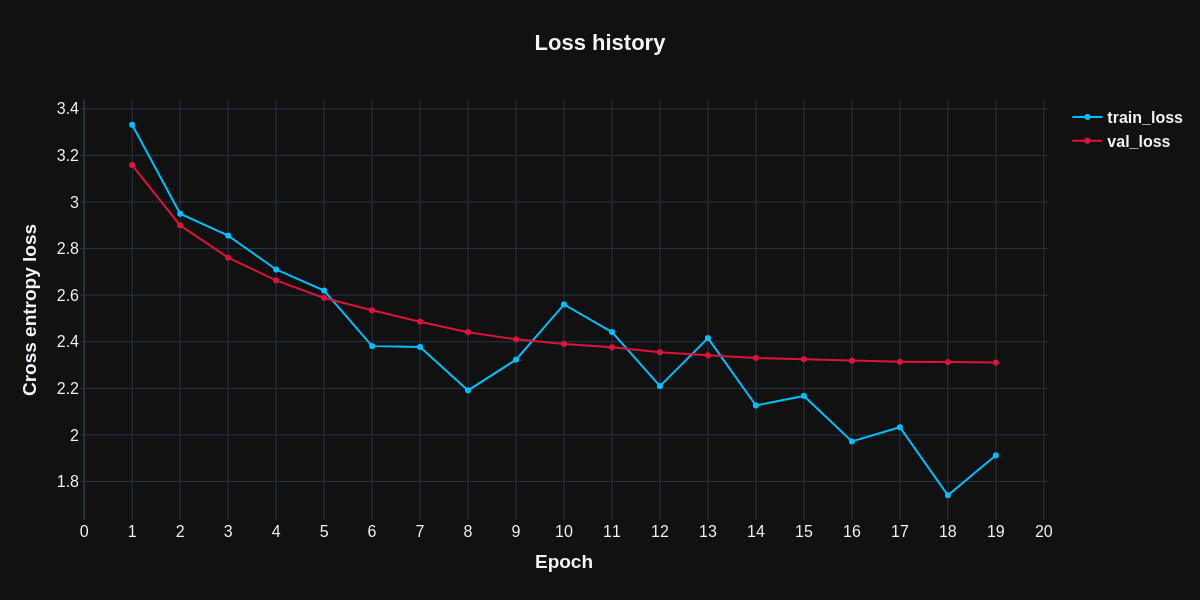

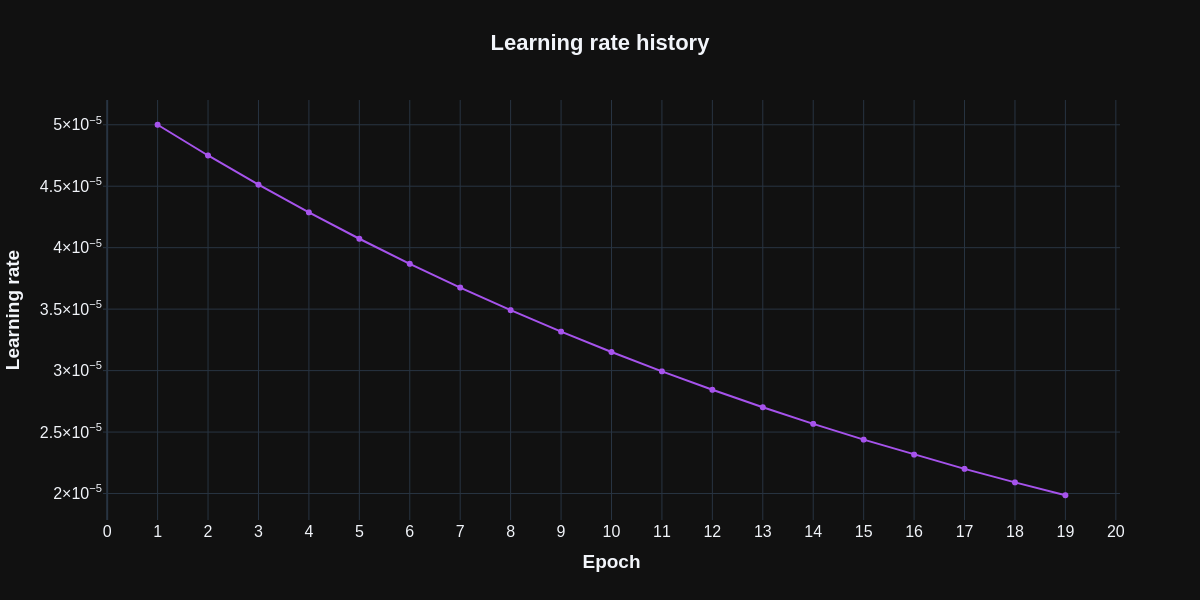

In [7]:
history_visualizer = History('logs/lightning_logs/version_3/metrics.csv')
history_visualizer.draw_history()

## Visualize predictions from test set

a man in a blue shirt is loading goods into a truck .


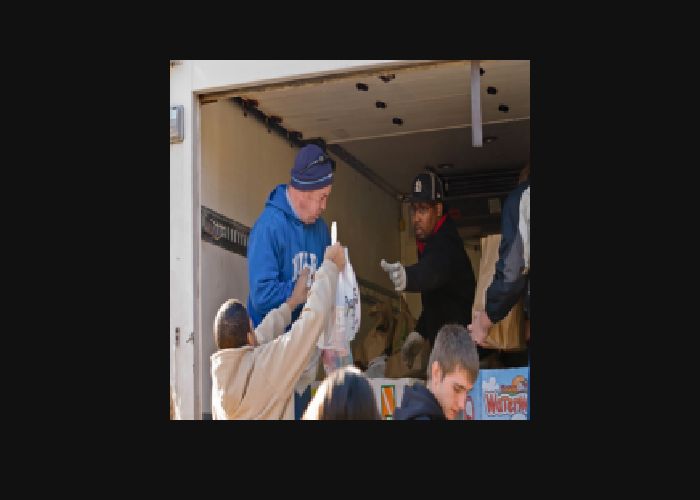

a woman in a dress walks down the street .


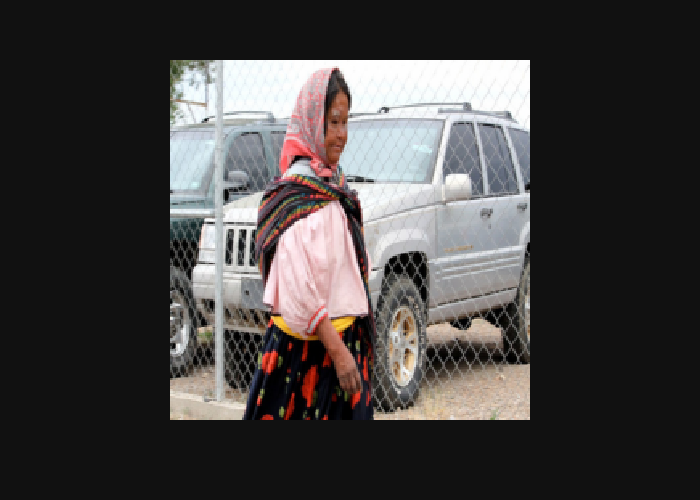

a woman in a red shirt taking pictures on a cellphone .


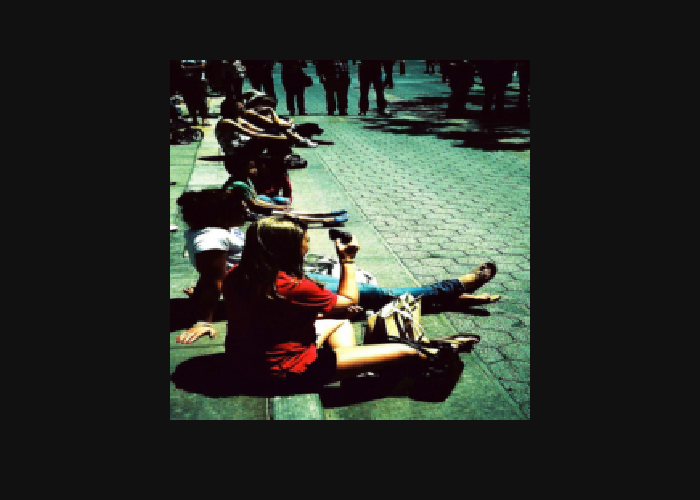

a crowd of people are cheering .


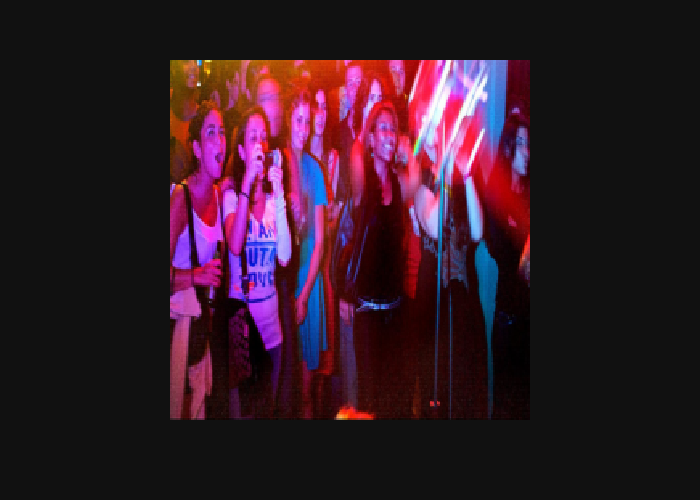

two women walking down the street .


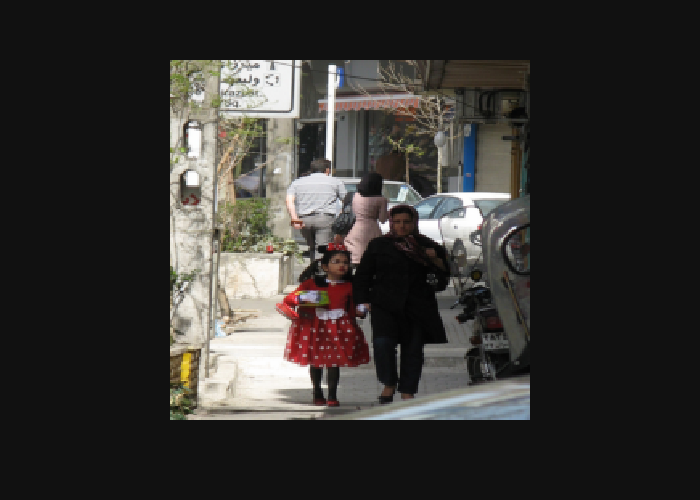

a little boy in a red shirt is sitting on a wooden chair .


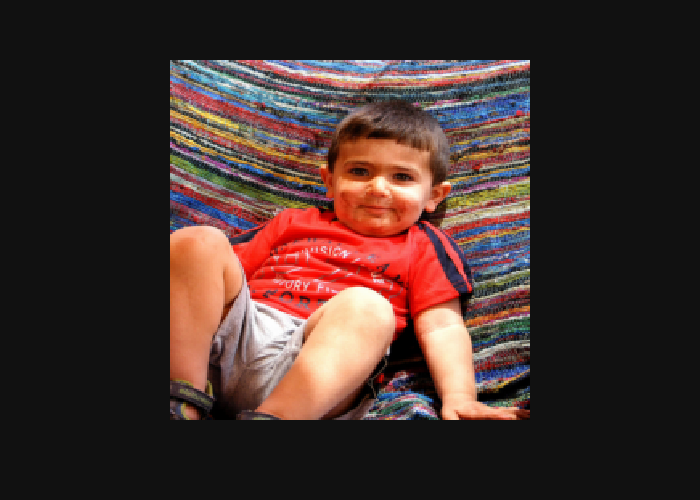

a man in a red life vest is jumping off a rock into a pool of water .


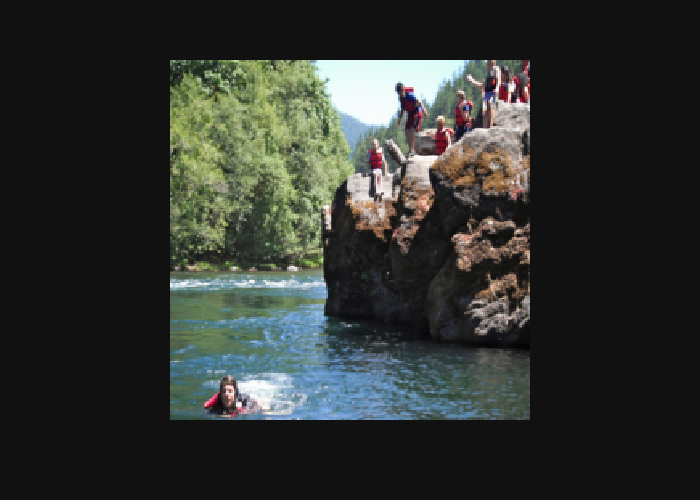

a woman in a black dress and a man in a white shirt are sitting on a wooden floor .


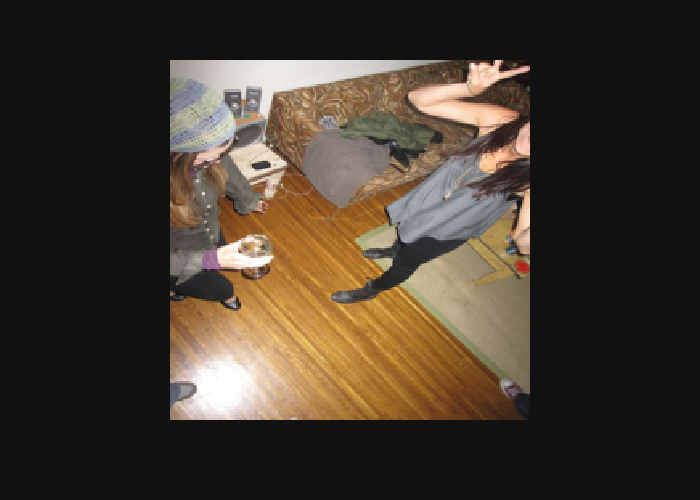

three race cars racing around a track .


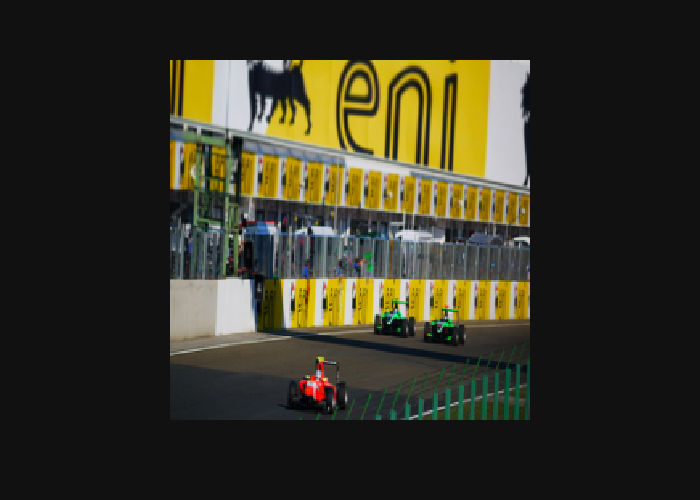

a young asian boy is playing a game of checkers .


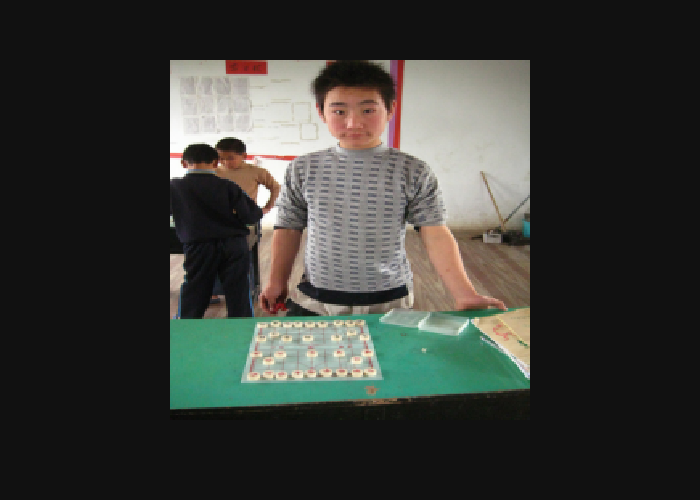

In [10]:
predictions_visuazlier = Predictor()
predictions_visuazlier.caption_dataloader(dataloader=dataloader_test, model=model, n_samples=10)